## Process terminus delineation results for all glaciers in one batch of analysis

By Jukes Liu. _Last modified 02-15-2020._

### Import necessary packages and functions

In [24]:
import numpy as np
import os
import pandas as pd    
import scipy.stats
import datetime
import math
import shutil
import subprocess
os.chdir('/home/jukes/automated-glacier-terminus')
from Results_per_glacier import calc_changerates1, to_datetimes, within, remove_dips, remove_jumps

csvpaths = '/home/jukes/Documents/Sample_glaciers/'
basepath = '/media/jukes/jukes1/LS8aws/'
massorsize = "mass"

ModuleNotFoundError: No module named 'Results_per_glacier'

In [13]:
#function to help us find the intersection of a line and a collection of points:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

In [14]:
def to_datetimes(df):
    datetimes = df.loc[:,'datetimes']; datetime_objs = []
    for date in datetimes:
        datetime_obj = datetime.datetime.strptime(str(date), '%Y-%m-%d'); datetime_obj = np.datetime64(datetime_obj)
        datetime_objs.append(datetime_obj)
    df['datetimes'] = datetime_objs
    return df

In [10]:
#define a function to calculate terminus change rate:
def calc_changerates1(df):
    df = df.dropna(subset=['tpos'])
    original_len = df.shape[0]; tchange= []   
    for i in range(0, len(df.index)):
        date = list(df['datetimes'])[i]; tpos = list(df['tpos'])[i]        
        #CALCULATE TERMINUS CHANGE RATE
        #grab the earliest date
        earliestdate = list(df['datetimes'])[0]
        #for the first date, the changerate is nan
        if date == earliestdate:
            changerate = np.NaN
        #for all other subsequent entries:
        else:
            #grab current date and terminus positions
            t = date; x = tpos;        
            #grab previous date of analysis 
            counter = 1; t_prev = list(df['datetimes'])[i-counter]
            #while the previous date = current date, append the counter and find the date before that!
            while t_prev == t:
                counter = counter+1; t_prev = list(df['datetimes'])[i-counter]
            #grab all terminus positions from previous date of analysis:
            prev_df = df[df['datetimes'] == t_prev].copy()
            positions = list(prev_df.tpos)
            #if there are multiple, grab the average of all of them
            x_prev = np.nanmean(np.array(positions));
            #calculate terminus change for center (dx) in meters and time change (dt in days)
            dx = x - x_prev; dt = t - t_prev; dt = dt.days; changerate = dx/dt             
        tchange.append(changerate);
    df['changerate'] = tchange
    return df

In [11]:
def remove_dips(df, flow_thresh, iterations):
    for iteration in range(0, iterations):
        #reset index
        df = df.reset_index(drop=True)
        dip_indices = [];
        # for index, row in onepick_df.iterrows():
        for index, row in df.iterrows():
            date = row['datetimes']
            rate = row['changerate']
            #for negative change rates:
            if rate < 0 and rate < -flow_thresh:
                #check the next entry only if it's in the range of indices
                if index+1 < len(df.index):  
                    counter = 1
                    #pick the next immediate rate/date
                    nextrate= df.loc[index+counter]['changerate']; nextdate = df.loc[index+counter]['datetimes']                    
                    #while the next date is the same as the current, increment the counter
                    #to grab the next next date until the next date is different from the current
                    while nextdate == date and index+counter < len(df.index)-1:
                        counter = counter + 1; nextrate = df.loc[index+counter]['changerate']
                        nextdate = df.loc[index+counter]['datetimes']

                    #if it's a sudden jump, then we have found a dip. Remove it
                    if nextrate > abs(flow_thresh):
                        dip_indices.append(index)
                            
                #if it's a crazy large negative change, 
                #remove it even if there isn't a positive change following
                if rate < -(15*abs(flow_thresh)):
                    dip_indices.append(index)            
        print(dip_indices)
        #REMOVE THOSE TERMINUS POSITIONS
        df = df.drop(dip_indices)
        #recalculate terminus changerates
        df = calc_changerates1(df)
    return df

In [12]:
def remove_jumps(df, flow_thresh, iterations):
    for iteration in range(0, iterations):
        #reset index for final_images_df
        df = df.reset_index(drop=True); jump_indices = []

        for i in range(0, len(df.index)):
            date = list(df['datetimes'])[i]; rate = list(df['changerate'])[i]
            tpos = list(df['tpos'])[i]; index = list(df.index)[i]

            if rate > abs(flow_thresh):
                #remove it:
                jump_indices.append(index)

            #remove drops if they are due to first value for the season
            #grab previous date of analysis 
            counter = 1; prev_date = list(df['datetimes'])[i-counter]
            #while the previous date = current date, append the counter and find the previous previous date
            while prev_date == date:
                counter = counter+1; prev_date = list(df['datetimes'])[i-counter]
            delta_date = date - prev_date; delta_date = delta_date.days

            #if the time gap is more than 2 months, and has a positive change rate
            #and the terminus position is more than 80% of the max,
            tpos_thresh = 0.8*np.max(np.array(df['tpos']))
            #remove it
            if delta_date > 60 and rate > 0:
                if tpos > tpos_thresh:
                    jump_indices.append(index)
        print(jump_indices)
        #drop the indices and reclaculate terminus change rates
        df = df.drop(jump_indices)
        df = calc_changerates1(df)
        
    return df

### Read in data from csv files

In [3]:
#IMAGE DATES
datetime_df = pd.read_csv(csvpaths+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(datetime_df.shape)

(864, 2)


In [4]:
analysis_date = '2020_02_05'
#DELINEATION METRIC AND ORDER 
for file in os.listdir(csvpaths):
    if analysis_date in file and file.endswith('.csv'):
        thefile = file
order_df = pd.read_csv(csvpaths+thefile, sep=',', dtype=str, header=1, usecols=[0,1,2,3,4])
order_df = order_df.dropna()

In [5]:
#CENTERLINE INFO
centerline_df = pd.read_csv(csvpaths+'Boxes_coords_pathrows.csv', sep=',', dtype=str, header=0)
centerline_df = centerline_df.set_index('BoxID')

In [6]:
#GLACIER VELOCITIES
flowspeed_df= pd.read_csv(csvpaths+'Glacier_vel_measures_sample10.csv', sep=',', dtype=str)
flowspeed_df = flowspeed_df.set_index('BoxID')

### Grab BoxIDs of all glaciers analyzed:

In [18]:
BoxIDs = list(set(order_df.BoxID))

### Run analysis of results for each glacier in a loop:

Box174


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 55, 56, 136, 144, 145, 146, 147, 148]
[]
[]
[61, 62, 63, 64, 100, 101, 102, 127, 128, 129, 130, 131, 150, 151, 152, 153, 154]
[96]
[]
[4, 5, 6, 7, 8, 15, 16, 17, 18, 19, 21, 22, 23, 62, 63, 64, 120, 145, 146, 147, 148, 149, 158, 158, 159, 159, 160, 160, 161, 161, 162, 162]
[6, 8, 136, 137, 138]
[4]
[6, 24, 26, 27, 28, 50, 80, 85, 94, 95, 96, 97, 110, 111, 124, 125, 150, 151]
[24, 45, 46, 78, 79, 80, 81, 82, 86, 87, 99, 110, 134, 135]
[5, 15, 16, 17, 18, 19, 20, 21, 32, 34, 35, 37, 48, 49, 50, 60, 61, 62, 94, 94, 96, 97, 98, 109, 117, 118, 119, 120, 121, 134, 135, 156, 157, 158, 159]
[76, 107, 108]
[5, 7, 22, 25, 26, 27, 34, 35, 36, 37, 38, 39, 40, 47, 61, 62, 68, 69, 70, 71, 80, 82, 83, 87, 88, 89, 90, 98, 98, 99, 99, 104, 105, 116, 117, 123, 124, 125, 131, 132, 134, 135, 149]
[22, 23, 60, 64, 65, 66, 67, 68, 95, 96]
35
36
34
35
36
34
35
36
34


/home/jukes/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


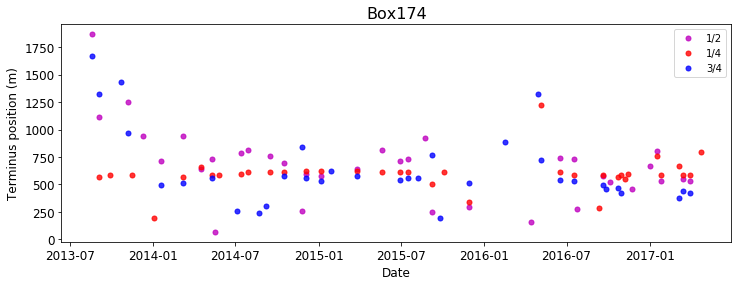

Box004


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[40, 41, 44, 44, 52, 52, 60, 60, 61, 61, 62, 62, 64, 64, 68, 88, 88, 89, 89, 103, 104, 105, 115, 115, 120, 121, 122, 130, 131, 133, 134, 135, 140, 141, 141, 142, 142, 156, 156, 216, 217, 218, 219, 220, 228, 228, 232, 232, 234, 241, 241, 242, 242, 248, 288, 289, 290, 291, 292, 306, 307, 308, 316, 317, 320, 320, 321, 324]
[57, 57, 60, 60, 189, 196, 200, 206, 212, 213, 272, 273]
[57, 57, 187, 193]
[59, 59, 65, 76, 77, 78, 79, 80, 81, 82, 83, 139, 139, 144, 144, 145, 145, 153, 153, 161, 161, 164, 165, 167, 167, 175, 175, 176, 176, 194, 195, 197, 202, 203, 204, 205, 206, 302, 302, 325, 325, 334, 334, 341, 341, 342, 342, 346, 346, 347, 347, 351, 352, 356, 357, 375, 375, 376, 376, 377, 377, 378, 378, 381, 385, 386, 387, 388, 389, 448]
[64, 143, 147, 147, 150, 151, 152, 153, 154, 157, 158, 158, 159, 321, 322, 341, 342]
[310]
[2, 4, 5, 65, 65, 66, 66, 67, 69, 69, 75, 75, 77, 77, 78, 78, 79, 79, 82, 83, 123, 125, 125, 126, 126, 127, 127, 139, 139, 140, 140, 141, 141, 142, 142, 146, 146, 150, 151

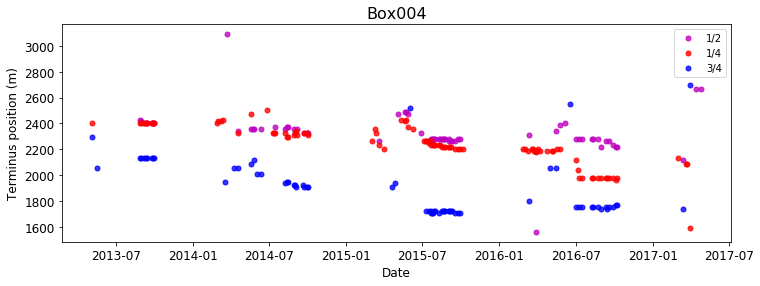

Box235


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[11, 12, 13, 24, 25, 30, 31, 32, 33, 34, 36, 37, 42, 42, 44, 44, 45, 45, 47, 48, 51, 52, 53, 54, 70, 71, 72, 73, 74, 89, 90, 90, 91, 92, 93, 107, 108, 109, 110, 121, 136, 141, 142, 145, 146, 150, 151, 163, 172, 182, 183, 184, 206, 206, 213, 214, 215, 216, 217, 218, 219, 220, 221, 226, 226, 227, 227, 228, 228, 229, 229, 230, 230, 243, 247, 252, 253, 254, 255, 274, 275, 275, 276]
[9, 10, 22, 23, 24, 35, 38, 86, 87, 88, 89, 95, 98, 101, 102, 109, 137, 138, 158, 159, 160, 161, 162, 187, 188, 189, 190, 191, 205, 206, 207, 208, 209]
[88, 90, 96, 97, 98]
[14, 16, 16, 17, 17, 18, 18, 31, 32, 33, 34, 35, 36, 37, 39, 44, 44, 45, 45, 46, 46, 68, 74, 92, 95, 98, 99, 106, 106, 109, 118, 119, 120, 121, 140, 141, 147, 154, 155, 161, 162, 163, 164, 165, 167, 167, 168, 168, 169, 169, 170, 170, 176, 178, 185, 186, 200, 200, 201, 201, 202, 202, 203, 203, 204, 204]
[28, 32, 33, 34, 118, 119, 120, 121, 122, 124, 124, 125, 125, 126, 126, 127, 127, 132, 133, 154]
[114]
[6, 8, 9, 21, 21, 22, 22, 27, 28, 29, 3

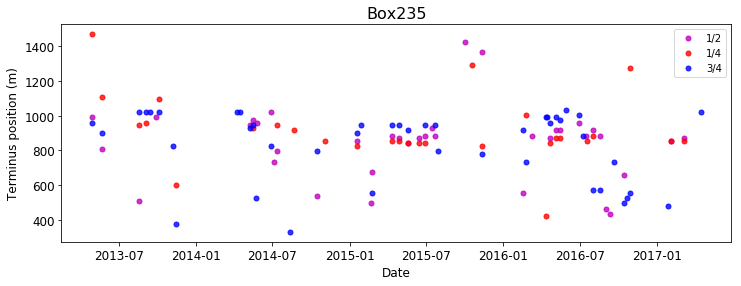

Box259


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 69, 72, 73, 74, 78, 81, 82, 83, 84, 85, 95, 96, 97, 103, 104, 105, 139, 140, 140, 141, 142, 142, 145, 146, 147, 148, 149, 150, 158, 159, 160, 223, 224, 233, 233, 234, 234, 240, 241, 243, 245, 246, 261, 262, 263, 264, 265, 270, 271, 272, 273, 274]
[75, 77, 78, 117, 120, 121, 123, 124, 125, 126, 188, 204, 214, 215, 216]
[71, 72, 74, 77, 78, 192, 195]
[39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 51, 54, 55, 56, 74, 75, 76, 82, 111, 113, 115, 188, 189, 190, 190, 191, 191, 198, 198, 199, 202, 204, 213, 214, 215, 217, 218, 219, 220, 221]
[60, 62, 63, 99, 180, 181, 182, 183, 185, 186, 187]
[58, 62, 63]
[53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 69, 70, 74, 74, 119, 123, 123, 126, 127, 128, 129, 130, 131, 132, 140, 141, 143, 144, 194, 196, 196, 197, 197, 198, 198, 202, 204, 205, 208, 213, 218, 219, 220, 221, 222, 227, 228, 229, 230, 231]
[108, 110, 116, 117, 119, 119, 120, 120, 121, 121, 122, 122, 124, 125, 126, 127, 172, 179, 180]
[]
[6, 21, 22, 23, 24, 25, 

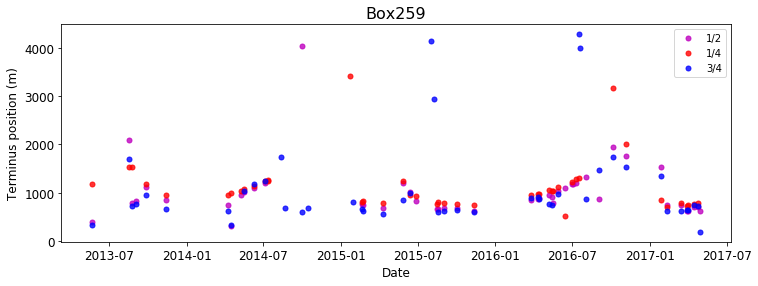

Box120


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[9, 32, 33, 34, 52, 53, 54, 55, 56, 80, 85, 86, 87, 88, 89, 90, 91, 92, 121, 122, 123, 124, 125, 139, 140, 154, 165, 166, 167, 168, 190, 191, 208, 209, 218, 219, 220, 221, 224, 225, 245, 246, 270, 271, 273, 274, 282, 286, 291, 292, 296, 297, 307, 308, 330, 331, 332, 333, 334]
[8, 28, 32, 33, 34, 35, 36, 108, 109, 110, 111, 112, 113, 114, 115, 243, 244, 245, 255, 256, 257, 258, 259, 260, 261, 262]
[228, 229, 230, 231, 232, 233]
[7, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 101, 102, 103, 105, 116, 117, 127, 128, 133, 136, 137, 138, 139, 140, 141, 143, 145, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 179, 180, 213, 214, 221, 222, 223, 231, 232, 235, 238, 239, 253, 254, 259, 263, 264, 265, 266, 267, 268, 270]
[64, 108, 209]
[]
[8, 9, 104, 113, 113, 123, 135, 135, 137, 138, 139, 140, 141, 142, 143, 154, 155, 156, 181, 182, 183, 192, 193, 194, 195, 206, 207, 208, 231, 254, 264, 279, 280, 281, 282, 283, 290, 302, 303]
[228, 229, 230, 231, 232, 235]
[]
[4, 6, 7, 26, 27, 28, 29, 48, 55, 56

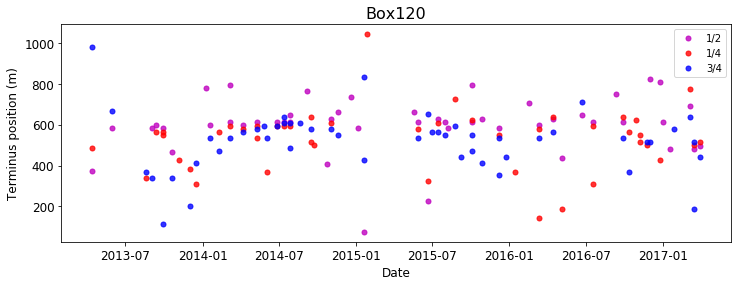

Box002


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[29, 45, 47, 149, 150, 152, 153, 154, 155, 156, 160, 169, 169, 171, 171, 245, 258, 259, 264, 272, 274, 275, 276, 277, 303, 304, 304, 339, 339, 350, 351, 365]
[29, 147, 149, 159, 244, 245, 246, 247]
[240, 241]
[24, 33, 34, 35, 36, 149, 159, 162, 164, 164, 167, 167, 168, 168, 250, 251, 252, 253, 254, 264, 265, 266, 267, 268, 269, 270, 271, 272, 277, 278, 279, 296, 297, 318, 320, 320, 323, 351, 352, 353, 368, 369, 370, 371]
[28, 29, 141, 142, 143, 149, 150, 151, 152, 155, 157, 263, 264, 327, 328, 329, 330, 331]
[24, 25, 26, 27, 139, 140, 141, 142, 143]
[28, 34, 34, 85, 85, 90, 98, 98, 107, 137, 137, 138, 138, 139, 139, 162, 174, 174, 182, 187, 187, 192, 193, 218, 222, 222]
[94, 95, 96, 164]
[159]
[31, 32, 33, 34, 35, 54, 105, 106, 141, 142, 143, 144, 146, 148, 149, 154, 157, 158, 174, 234, 235, 236, 237, 238, 240, 241, 242, 243, 251, 252, 330]
[31, 32, 33, 34, 35, 49, 50, 51, 52, 53, 139, 141, 142, 143, 144, 145, 216, 217]
[27, 28, 29, 108, 109, 110, 111, 112, 131, 132, 133, 134, 142, 143

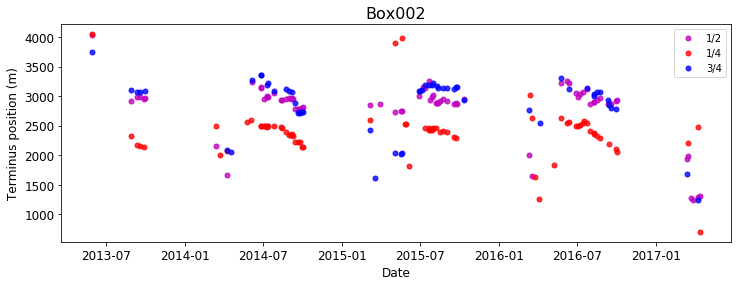

Box001


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[50, 51, 52, 53, 54, 95, 96, 97, 98, 99, 170, 171, 172, 173, 174, 177, 180, 233, 234, 235, 236, 237, 394, 395, 396, 397, 398, 404, 404, 405, 405, 406, 406, 407, 407, 408, 408, 426, 432, 433, 434, 435, 436, 460, 560, 561, 562, 563, 564]
[90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 422, 423, 424, 425, 426]
[91, 92, 93, 94]
[86, 87, 88, 89, 90, 161, 162, 163, 164, 165, 223, 223, 224, 224, 225, 225, 226, 226, 227, 255, 399, 400, 401, 402, 410, 412, 413, 414, 415, 416, 441, 441, 442, 442, 443, 443, 444, 444, 445, 445, 537, 538, 539, 540, 541, 567, 568, 569, 570, 571]
[86, 86, 87, 87, 88, 88, 89, 89, 90, 90]
[87, 88, 89]
[40, 41, 42, 43, 44, 44, 55, 56, 57, 58, 99, 100, 101, 102, 103, 226, 392, 392, 393, 393, 394, 394, 395, 395, 396, 396, 412, 412, 413, 414, 415, 416, 416, 424, 446]
[40, 41, 42, 43, 44, 90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 387, 388, 389, 390, 391]
[86, 87, 88, 89]
[5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 55, 56, 57, 58, 59, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 167, 

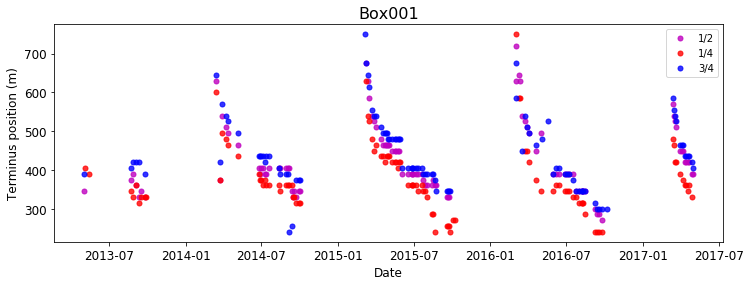

Box277


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[85, 86, 87, 88, 89, 105, 112, 113, 138, 139, 140, 141, 142, 158, 159, 326, 328, 349, 350, 351, 352, 353]
[95]
[]
[86, 87, 88, 89, 112, 113, 163, 338, 339, 340, 341, 342]
[]
[]
[9, 58, 59, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 85, 86, 87, 88, 89, 105, 112, 113, 140, 141, 142, 143, 144, 162, 162, 165, 165, 170, 170, 171, 171, 172, 172, 173, 173, 191, 218, 219, 220, 221, 222, 230, 231, 232, 238, 239, 240, 241, 242, 333, 334, 335, 361, 362, 363, 364, 380, 381, 382, 383, 384]
[65, 66, 82, 132, 133]
[]
[122, 125, 125, 126, 126, 128, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 188, 189, 190, 191, 192, 208, 209, 210, 211, 212, 218, 219, 220, 221, 222, 273, 274, 275, 276, 277, 303, 304, 305, 306, 307, 344, 345, 346, 347, 348]
[45, 46, 47, 48, 49, 124, 130, 131, 132, 133, 134, 184, 185, 270, 271, 287, 288, 289, 290, 291]
[86, 87, 88, 89, 90, 126, 134, 135, 136, 137, 138, 150, 151, 152, 153, 154, 155, 156, 170, 171, 172, 173, 174, 176, 177, 178, 193, 194, 195, 196, 197, 222, 223, 224, 22

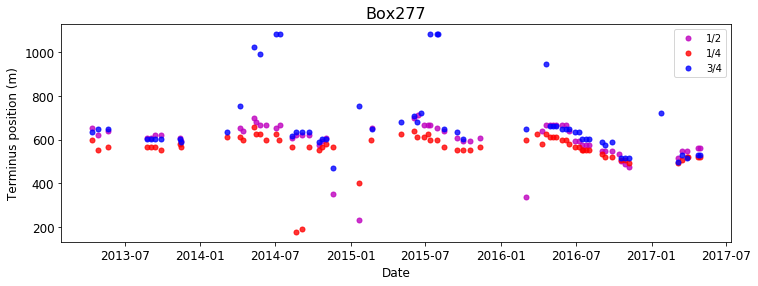

Box531


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[2, 3, 3, 30, 31, 32, 33, 34, 36, 38, 54, 55, 56, 57, 58, 59, 60, 73, 73, 74, 74, 78, 78, 79, 79, 80, 80, 86, 87, 88, 89, 90, 96, 97, 100, 102, 122, 122, 123, 123, 139, 149, 149, 150, 150, 154, 155, 164, 164, 168, 169, 173, 174, 175, 176, 177, 187, 188, 189, 199, 205, 206, 207, 208, 209, 215, 216, 222, 223, 224, 225, 226, 232, 233, 234, 235, 236, 254, 255, 259, 259, 262, 264, 265, 266, 294, 294, 295, 295, 302, 302, 307, 308, 309]
[26, 45, 45, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 73, 74, 91, 116, 117, 118, 125, 126, 129, 133, 134, 135, 151, 156, 157, 158, 159, 160, 166, 167, 170, 171, 172, 173, 174, 175]
[44, 45, 46, 61, 62, 63, 64, 65, 104, 105, 107, 108, 127, 128, 129, 130, 132, 133, 138, 139, 140, 141]
[33, 34, 35, 44, 45, 49, 50, 51, 52, 53, 68, 69, 74, 75, 87, 87, 88, 88, 89, 89, 90, 90, 97, 98, 99, 136, 144, 145, 146, 147, 148, 158, 159, 164, 164, 165, 165, 166, 166, 167, 167, 173, 177, 179, 179, 184, 184, 185, 185, 186, 187, 188, 191, 196, 196, 197, 197, 198, 198, 199, 199, 20

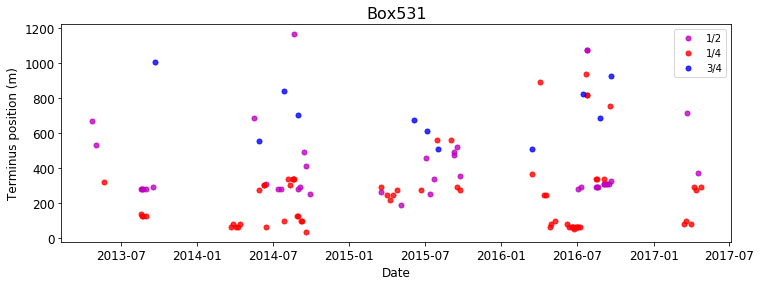

Box033


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[44, 45, 46, 47, 48, 115, 116, 117, 118, 119, 129, 129, 130, 130, 167, 168, 169, 170, 201, 201, 202, 202, 203, 203, 204, 204, 205, 205, 216, 217, 218, 219, 220, 231, 232, 233, 234, 235, 246, 246, 247, 247, 248, 248, 249, 249, 250, 250, 284, 286, 286, 287, 287, 288, 288, 289, 289, 290, 290, 301, 301, 302, 302, 303, 303, 304, 304, 361, 362, 363, 364, 365, 381, 382, 383, 384, 385, 487, 488, 489, 490, 491, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552]
[240, 241, 242, 244, 245, 246, 247, 251, 252, 253, 256, 257, 258, 259, 260, 261, 262, 263, 431, 432, 433, 434]
[235, 236, 237, 239, 242, 251, 413, 414, 415, 416, 417, 418, 419, 420, 421]
[37, 38, 39, 40, 41, 204, 204, 205, 205, 206, 206, 207, 207, 208, 208, 225, 226, 227, 229, 241, 242, 243, 244, 245, 289, 290, 291, 292, 293]
[216, 217, 218, 219, 220, 221, 222]
[216]
[102, 122, 123, 124, 151, 152, 189, 190, 191, 192, 193, 204, 205, 206, 207, 208, 219, 220, 221, 222, 223, 228, 229, 230, 231, 232, 261, 272, 272, 273, 273, 274, 274, 275, 275

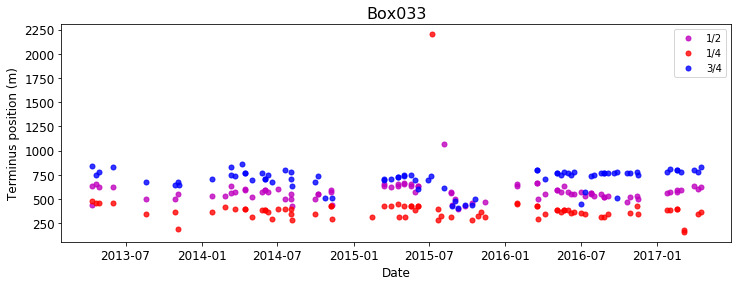

In [19]:
for BOI in BoxIDs:
    print("Box"+BOI)
    metric = "Datfiles/"; imagepath = basepath+"Box"+BOI+"/rotated/"
    
    order_box_df = order_df[order_df["BoxID"]==BOI].copy()
    order_box_df = order_box_df.drop('BoxID', axis=1)
    order_box_df = order_box_df.dropna()
    
    #GRAB INFO FROM IMAGE FILES
    image_arrays = []; dats = []; trimdats = []; imgnames = []; boxids = []; scales = []
    imgfiles = os.listdir(imagepath)
    for imgfile in imgfiles:
        #grab image files and append to images list
        if imgfile.endswith(BOI+".png"):
            image = mpimg.imread(imagepath+imgfile); imgname = imgfile[0:-4]; scenename = imgname[2:23]
            pathtodat = imagepath+imgname+".pgm_max_gaussian/"+metric
            datfiles = os.listdir(pathtodat)
            #if there are datfiles, grab the trimmed and non-trimmed files
            if len(datfiles) > 1: 
                #find the trimmed dat file and the original
                for dat in datfiles:
                    if "trim" in dat:
                        datfile_trim = dat
                        #append to trimmed dats list
                        trimdats.append(datfile_trim)
                        #grab the scale and append the equivalent original dat
                        scale = dat[-7:-4]
                        datfile = "terminus_"+scale+".dat"
                        dats.append(datfile)
                        #append the image array and the image name to the list
                        image_arrays.append(image); imgnames.append(scenename); boxids.append(BOI); scales.append(scale)
    images_df = pd.DataFrame(list(zip(imgnames, boxids, image_arrays, dats, trimdats, scales)),
                  columns=['Scene','BoxID','Image_array', 'Dat_filename', "Trimmed_dat_filename", "Scale"])
    images_df.sort_values(by='Scene'); datetime_df = datetime_df.sort_values(by='Scene')
    
    #MERGE IMAGE INFO WITH IMAGEDATES AND MERGE WITH ORDER
    new_df = images_df.merge(datetime_df, how= 'inner', on = 'Scene')
    dated_images_df = new_df.sort_values(by='datetimes', ascending = True)
    final_images_df = dated_images_df.merge(order_box_df, how='inner', on=['Scene', 'Scale'])
    final_images_df = final_images_df.sort_values(by=['datetimes','Scene','Order'], ascending=True)
    
    #CALCULATE TERMINUS POSITIONS
    #LOAD IN REFERENCE POINTS to calculate terminus position with respect to
    box_midpoint_x = np.float(centerline_df.loc[BOI, 'lmid50_x']); box_midpoint_y = np.float(centerline_df.loc[BOI, 'lmid50_y'])
    boxmid_x_25 = np.float(centerline_df.loc[BOI, 'lmid25_x']); boxmid_y_25 = np.float(centerline_df.loc[BOI, 'lmid25_y'])
    boxmid_x_75 = np.float(centerline_df.loc[BOI, 'lmid75_x']); boxmid_y_75 = np.float(centerline_df.loc[BOI, 'lmid75_y'])

    #GRAB CENTERLINE POINTS
    #grab slopes and intercepts from the dataframe
    c_slope = float(centerline_df.loc[BOI]['m50']); c_intercept = float(centerline_df.loc[BOI]['b50']) 
    c25_slope = float(centerline_df.loc[BOI]['m25']); c25_intercept = float(centerline_df.loc[BOI]['b25'])
    c75_slope = float(centerline_df.loc[BOI]['m75']); c75_intercept = float(centerline_df.loc[BOI]['b75'])  

    #grab range of x-values
    xmin50 = float(box_midpoint_x); xmax50 = float(centerline_df.loc[BOI, 'rmid50_x']); ymid50 = float(box_midpoint_y)
    xmin25 = float(boxmid_x_25); xmax25 = float(centerline_df.loc[BOI, 'rmid25_x']); ymid25 = float(boxmid_y_25)
    xmin75 = float(boxmid_x_75); xmax75 = float(centerline_df.loc[BOI, 'lmid75_x']); ymid75 = float(boxmid_y_75)
    xmax = np.max([xmax50, xmax25, xmax75]); xmin = np.min([xmin50, xmin25, xmin75]); c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)

    #calculate y-values using the various centerlines
    c_y = c_slope*c_x + c_intercept; c_y_25 = c25_slope*c_x + c25_intercept; c_y_75 = c75_slope*c_x + c75_intercept

    #LISTS TO HOLD TERMINUS POSITIONS AND INTERSECTION POINTS
    terminus_positions = []; tpositions_25 = []; tpositions_75 = []
    intersections = []; X25 = []; X75 = []

    #for each scene and scale:
    for index, row in final_images_df.iterrows():
        trimdat = row['Trimmed_dat_filename']; dat = row['Dat_filename']; scene = row['Scene']    
        #CALCULATE TERMINUS POSITION
        #load in dat files and calculate intersection points
        datpath = imagepath+"R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    #     term_trimdat = np.loadtxt(datpath+trimdat)
        term_dat = np.loadtxt(datpath+dat)                          
        intersect_xs = []; intersect_xs_25 = []; intersect_xs_75 = []
        intersect_ys = []; intersect_ys_25 = []; intersect_ys_75 = []

        #loop through all the x,y values for the centerline
        for j in range(0, len(c_x)):
            x = c_x[j]; y = c_y[j]; y25 = c_y_25[j]; y75 = c_y_75[j]        
            interval = 0.6
            #where are the intersections with the terminus pick?
    #         for dat_x, dat_y in term_trimdat:
            for dat_x, dat_y in term_dat:
                #midway centerline
                if within(dat_x, x, interval) and within (dat_y, y, interval):
                    #intersect_x = dat_x; intersect_y = dat_y; intersect_found = True
                    intersect_xs.append(dat_x); intersect_ys.append(dat_y)            
                #1/4th centerline
                if within(dat_x, x, interval) and within (dat_y, y25, interval):
                    intersect_xs_25.append(dat_x); intersect_ys_25.append(dat_y)              
                #3/4th centerline
                if within(dat_x, x, interval) and within (dat_y, y75, interval):
                    intersect_xs_75.append(dat_x); intersect_ys_75.append(dat_y)
        #for 50 centerline
        #if no intersections are found with the terminus line, append Nans
        if len(intersect_xs) == 0:
            tpos50 = np.NaN; intersect_x = np.NaN; intersect_y = np.NaN
        #if at least one is found:
        else:
            #intersection with the greatest x
            #use distance formula to calculate distance between
            max_index = intersect_xs.index(np.max(intersect_xs))
            intersect_x = intersect_xs[max_index]; intersect_y = intersect_ys[max_index]
    #         term_position = distance(xmin50, ymid50, intersect_x, intersect_y)*15.0
            tpos50 = (intersect_x-xmin50)*15.0
    #         print(tpos50)

        #for 25 centerline
        if len(intersect_xs_25) == 0:
            tpos25 = np.NaN; intersect_x25 = np.NaN; intersect_y25 = np.NaN
        else:
            max_index_25 = intersect_xs_25.index(np.max(intersect_xs_25))
            intersect_x25 = intersect_xs_25[max_index_25]; intersect_y25 = intersect_ys_25[max_index_25]
            tpos25 = (intersect_x25-xmin25)*15.0
    #         tpos25 = distance(xmin25, ymid25, intersect_x25, intersect_y25)*15.0

        #for 75 centerline
        if len(intersect_xs_75) == 0:
            tpos75 = np.NaN; intersect_x75 = np.NaN; intersect_y75 = np.NaN
        else:
            max_index_75 = intersect_xs_75.index(np.max(intersect_xs_75))
            intersect_x75 = intersect_xs_75[max_index_75]; intersect_y75 = intersect_ys_75[max_index_75]
            tpos75 = (intersect_x75-xmin75)*15.0
    #         tpos75 = distance(xmin75, ymid75, intersect_x75, intersect_y75)*15.0

        #append to lists
        terminus_positions.append(tpos50); tpositions_25.append(tpos25); tpositions_75.append(tpos75)
        intersections.append([intersect_x, intersect_y]); X25.append([intersect_x25, intersect_y25]); X75.append([intersect_x75, intersect_y75])

    # ADD TERMINUS POSITION AND INTERSECTIONS
    final_images_df['tpos50'] = terminus_positions; final_images_df['tpos25'] = tpositions_25; final_images_df['tpos75'] = tpositions_75
    final_images_df['X50'] = intersections ;final_images_df['X25'] = X25; final_images_df['X75'] = X75
    
    #SPLIT INTO 3 DATAFRAMES FOR 3 FLOWLINES:
    final_images_50 = final_images_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                      'tpos50', 'X50',]].copy().reset_index(drop=True)
    final_images_50 = final_images_50.rename(columns={"tpos50": "tpos", "X50": "X"})
    final_images_25 = final_images_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                      'tpos25', 'X25']].copy().reset_index(drop=True)
    final_images_25 = final_images_25.rename(columns={"tpos25": "tpos", "X25": "X"})
    final_images_75 = final_images_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
                                      'tpos75', 'X75']].copy().reset_index(drop=True)
    final_images_75 = final_images_75.rename(columns={"tpos75": "tpos", "X75": "X"})
    dfs = [final_images_50, final_images_25, final_images_75]
    
    #CALCULATE TERMINUS CHANGE RATES
    dfs_new = []
    for df in dfs: 
        to_datetimes(df); dfs_new.append(calc_changerates1(df))
        
    #FILTER USING 5*MAXIMUM FLOW SPEEDS
    max_flow = float(flowspeed_df['Max_speed'][BOI])
    if max_flow < 1.0:
        flow_thresh = 5.0
    else:
        flow_thresh = 5.0*max_flow
    #remove dips
    N1 = 3; nodips = []
    for df in dfs_new:
        nodips.append(remove_dips(df, flow_thresh, N1))
    #remove jumps
    N2 = 2; nojumps = []
    for df in nodips:
        nojumps.append(remove_jumps(df, flow_thresh, N2))
        
    #GRAB HIGHEST ORDER PICK AFTER FILTERING
    highestorder_dfs = []
    for df in nojumps:
        #grab unique dates
        unique_dates = set(list(df['datetimes']))
        print(len(unique_dates))
        #grab highest orders:
        order_list = []
        for date in unique_dates:
            date_df = df[df['datetimes'] == date].copy()
            highestorder = np.min(np.array(date_df['Order']))
            order_list.append(highestorder)
        highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order']).sort_values(by='datetimes', ascending=True)
        highestorder_dfs.append(highestorder_df)
    
    onepick_dfs = []
    for i in range(0, len(highestorder_dfs)):
        onepick_df = nojumps[i].merge(highestorder_dfs[i], how='inner', on=['datetimes', 'Order'])
        onepick_dfs.append(onepick_df)
        print(onepick_df.shape[0])
    
    #PLOT AND SAVE
    fig, ax1 = plt.subplots(figsize=(12,4))
    markers = ['mo', 'ro', 'bo']
    for j in range(0, len(onepick_dfs)):
        df = onepick_dfs[j];    print(len(df))
        ax1.plot(df['datetimes'], df['tpos'], markers[j], markersize=5, alpha=0.8)
    #general plot parameters
    ax1.set_ylabel('Terminus position (m)', color='k', fontsize=12)
    ax1.set_title("Box"+BOI, fontsize=16); ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    #save figure
    plt.savefig(csvpaths+"/Figures/Termposition_LS8_m_Box"+BOI+"_"+analysis_date+".png", dpi=200)
    plt.legend(['1/2', '1/4', '3/4'])
    plt.show()
    
    flowlines = ['flowline50', 'flowline25', 'flowline75']
    for k in range(0, len(onepick_dfs)):
        df = onepick_dfs[k];
        df.to_csv(path_or_buf = csvpaths+'Tpos_Box'+BOI+'_'+flowlines[k]+'_filtered.csv', sep=',')